# Neural Network Performance on KMeans Clustering

### Import Packages

In [1]:
# tensorflow model imports
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# keras imports
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

# sklearn modeling imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import AffinityPropagation, KMeans, SpectralClustering

# other imports
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/spotify_tracks_genre.csv')

### Data Preprocessing

In [4]:
data = data.drop(labels = ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'],
                 axis = 1)

data["explicit"] = data["explicit"].replace({True:1, False:0})

# adding one-hot encoding of our categorical column time signature and key
data = pd.get_dummies(data, columns = ["time_signature","key"])

In [5]:
data

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,73,230666,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,...,0,0,0,0,0,0,0,0,0,0
1,55,149610,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,...,0,0,0,0,0,0,0,0,0,0
2,57,210826,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,71,201933,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,...,0,0,0,0,0,0,0,0,0,0
4,82,198853,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,0.2350,-16.393,1,0.0422,0.6400,0.928000,...,0,0,0,1,0,0,0,0,0,0
113996,22,385000,0,0.174,0.1170,-18.318,0,0.0401,0.9940,0.976000,...,0,0,0,0,0,0,0,0,0,0
113997,22,271466,0,0.629,0.3290,-10.895,0,0.0420,0.8670,0.000000,...,0,0,0,0,0,0,0,0,0,0
113998,41,283893,0,0.587,0.5060,-10.889,1,0.0297,0.3810,0.000000,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# KMeans

average_traits_by_genre = data.groupby('track_genre').mean()

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(average_traits_by_genre)

data_scaled = pd.DataFrame(scaled_features, columns=average_traits_by_genre.columns,
                           index=average_traits_by_genre.index)

# 20 clusters
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
average_traits_by_genre['cluster'] = kmeans.fit_predict(scaled_features)

# print clusters
for cluster in range(num_clusters):
    print(f"Cluster {cluster}:")
    genres_in_cluster = average_traits_by_genre[average_traits_by_genre['cluster'] == cluster].index.tolist()
    print(genres_in_cluster)
    print()

Cluster 0:
['anime', 'club', 'death-metal', 'deep-house', 'dub', 'dubstep', 'electronic', 'emo', 'groove', 'grunge', 'hardcore', 'hardstyle', 'industrial', 'j-idol', 'metalcore', 'progressive-house', 'turkish']

Cluster 1:
['guitar', 'honky-tonk', 'romance', 'tango']

Cluster 2:
['idm', 'iranian', 'study']

Cluster 3:
['bluegrass', 'brazil', 'gospel', 'mpb', 'pagode', 'psych-rock', 'samba', 'sertanejo', 'ska']

Cluster 4:
['ambient', 'classical', 'disney', 'new-age', 'opera', 'piano']

Cluster 5:
['alt-rock', 'alternative', 'garage', 'goth', 'hard-rock', 'heavy-metal', 'j-rock', 'metal', 'power-pop', 'punk', 'punk-rock', 'rock', 'spanish']

Cluster 6:
['breakbeat', 'chicago-house', 'detroit-techno']

Cluster 7:
['afrobeat', 'disco', 'forro', 'kids', 'party', 'synth-pop']

Cluster 8:
['chill', 'french', 'german', 'indian', 'indie', 'indie-pop', 'j-pop', 'k-pop', 'pop', 'pop-film', 'sad']

Cluster 9:
['acoustic', 'cantopop', 'folk', 'malay', 'mandopop', 'show-tunes', 'singer-songwriter',

In [7]:
# relabeling genres
for i in range(num_clusters):
  genres_in_cluster = average_traits_by_genre[average_traits_by_genre['cluster'] == i].index.tolist()
  if len(genres_in_cluster) == 0:
    break
  data = data.replace(genres_in_cluster, i)

# undersampling 1000 from each cluster
sampled_df = pd.DataFrame()
n = len(data["track_genre"].unique())
for i in range(n): # sample 1000
  cluster = data[data["track_genre"] == i]
  samples = cluster.sample(1000)
  sampled_df = pd.concat([sampled_df, samples], axis=0)

data = sampled_df

In [8]:
# train test split
X = data.drop(labels=['track_genre'], axis=1)
y = data['track_genre']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

n = int(len(data)/1000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Model Construction

In [9]:
# FCNN model
num_features = X_train.shape[1]
num_genres = np.unique(y_train).shape[0]

def create_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(512, activation=activation, input_shape=(num_features,)))
    model.add(Dense(256, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = activation))
    model.add(Dense(num_genres, activation = 'softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [10]:
model = create_model()

### Training

In [11]:
# scheduler to fine tune model learning
def scheduler(epoch, lr):
  return lr*0.9

callback = keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(X_train, y_train, batch_size = 32, verbose=1, epochs=20,
           validation_split=0.1, callbacks = [callback])

Epoch 1/20
450/450 [==============================] - 6s 10ms/step - loss: 2.0137 - accuracy: 0.3695 - val_loss: 1.8272 - val_accuracy: 0.4219 - lr: 9.0000e-04
Epoch 2/20
450/450 [==============================] - 3s 7ms/step - loss: 1.7425 - accuracy: 0.4492 - val_loss: 1.7225 - val_accuracy: 0.4406 - lr: 8.1000e-04
Epoch 3/20
450/450 [==============================] - 3s 7ms/step - loss: 1.6650 - accuracy: 0.4766 - val_loss: 1.6843 - val_accuracy: 0.4563 - lr: 7.2900e-04
Epoch 4/20
450/450 [==============================] - 4s 8ms/step - loss: 1.6173 - accuracy: 0.4924 - val_loss: 1.6533 - val_accuracy: 0.4631 - lr: 6.5610e-04
Epoch 5/20
450/450 [==============================] - 4s 9ms/step - loss: 1.5684 - accuracy: 0.4996 - val_loss: 1.6846 - val_accuracy: 0.4694 - lr: 5.9049e-04
Epoch 6/20
450/450 [==============================] - 3s 7ms/step - loss: 1.5354 - accuracy: 0.5132 - val_loss: 1.5744 - val_accuracy: 0.4963 - lr: 5.3144e-04
Epoch 7/20
450/450 [=========================

### Testing

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

125/125 [==============================] - 0s 3ms/step - loss: 1.5142 - accuracy: 0.5365
Test Loss: 1.5141658782958984
Test Accuracy: 0.5364999771118164


### Evaluation

125/125 [==============================] - 0s 3ms/step


Text(50.722222222222214, 0.5, 'True Label')

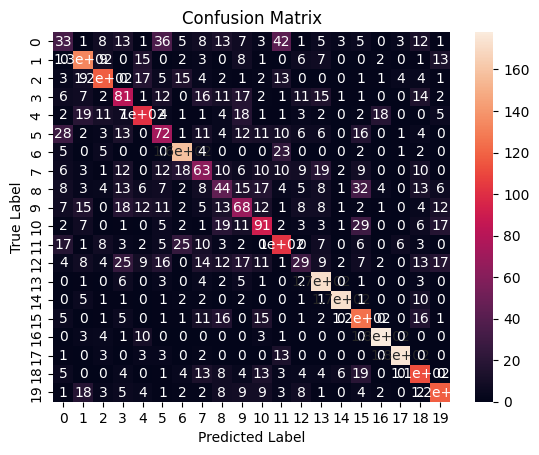

In [13]:
# confusion matrix to evaluate predictions
ypred = model.predict(X_test).argmax(axis=1)
cf_matrix = sklearn.metrics.confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

We can see from this plot that our model predicted genre clusters 13 and 6 really well, where cluster 13 refers to "salsa" and 6 refers to genres such as "chicago-house" and "detroit-techno". However, our model struggled to predict 12, which we can see that some of the genres included are "british", "children", and "country", which inutivitely we can identify as rather unsimilar music categories. We also see a lot of confusion around cluster 0, which is the largest cluster and contains a lot of variability within the grouping, and is reflected in the poor predictions our model was able to make.

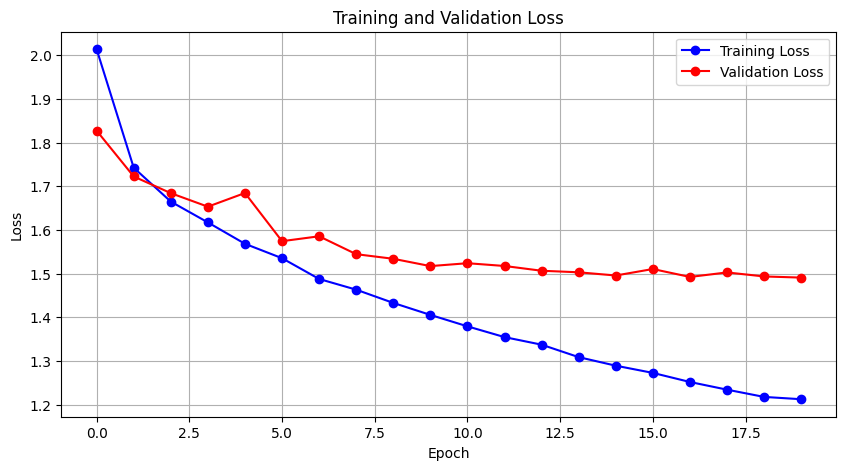

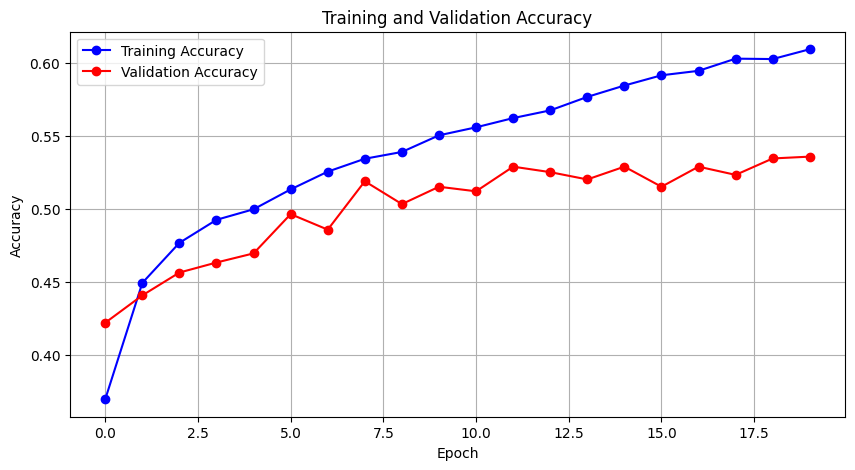

In [14]:
# extracting training and validation loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# extracting training and validation accuracy from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(val_loss, label='Validation Loss', color='red', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', color='red', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()